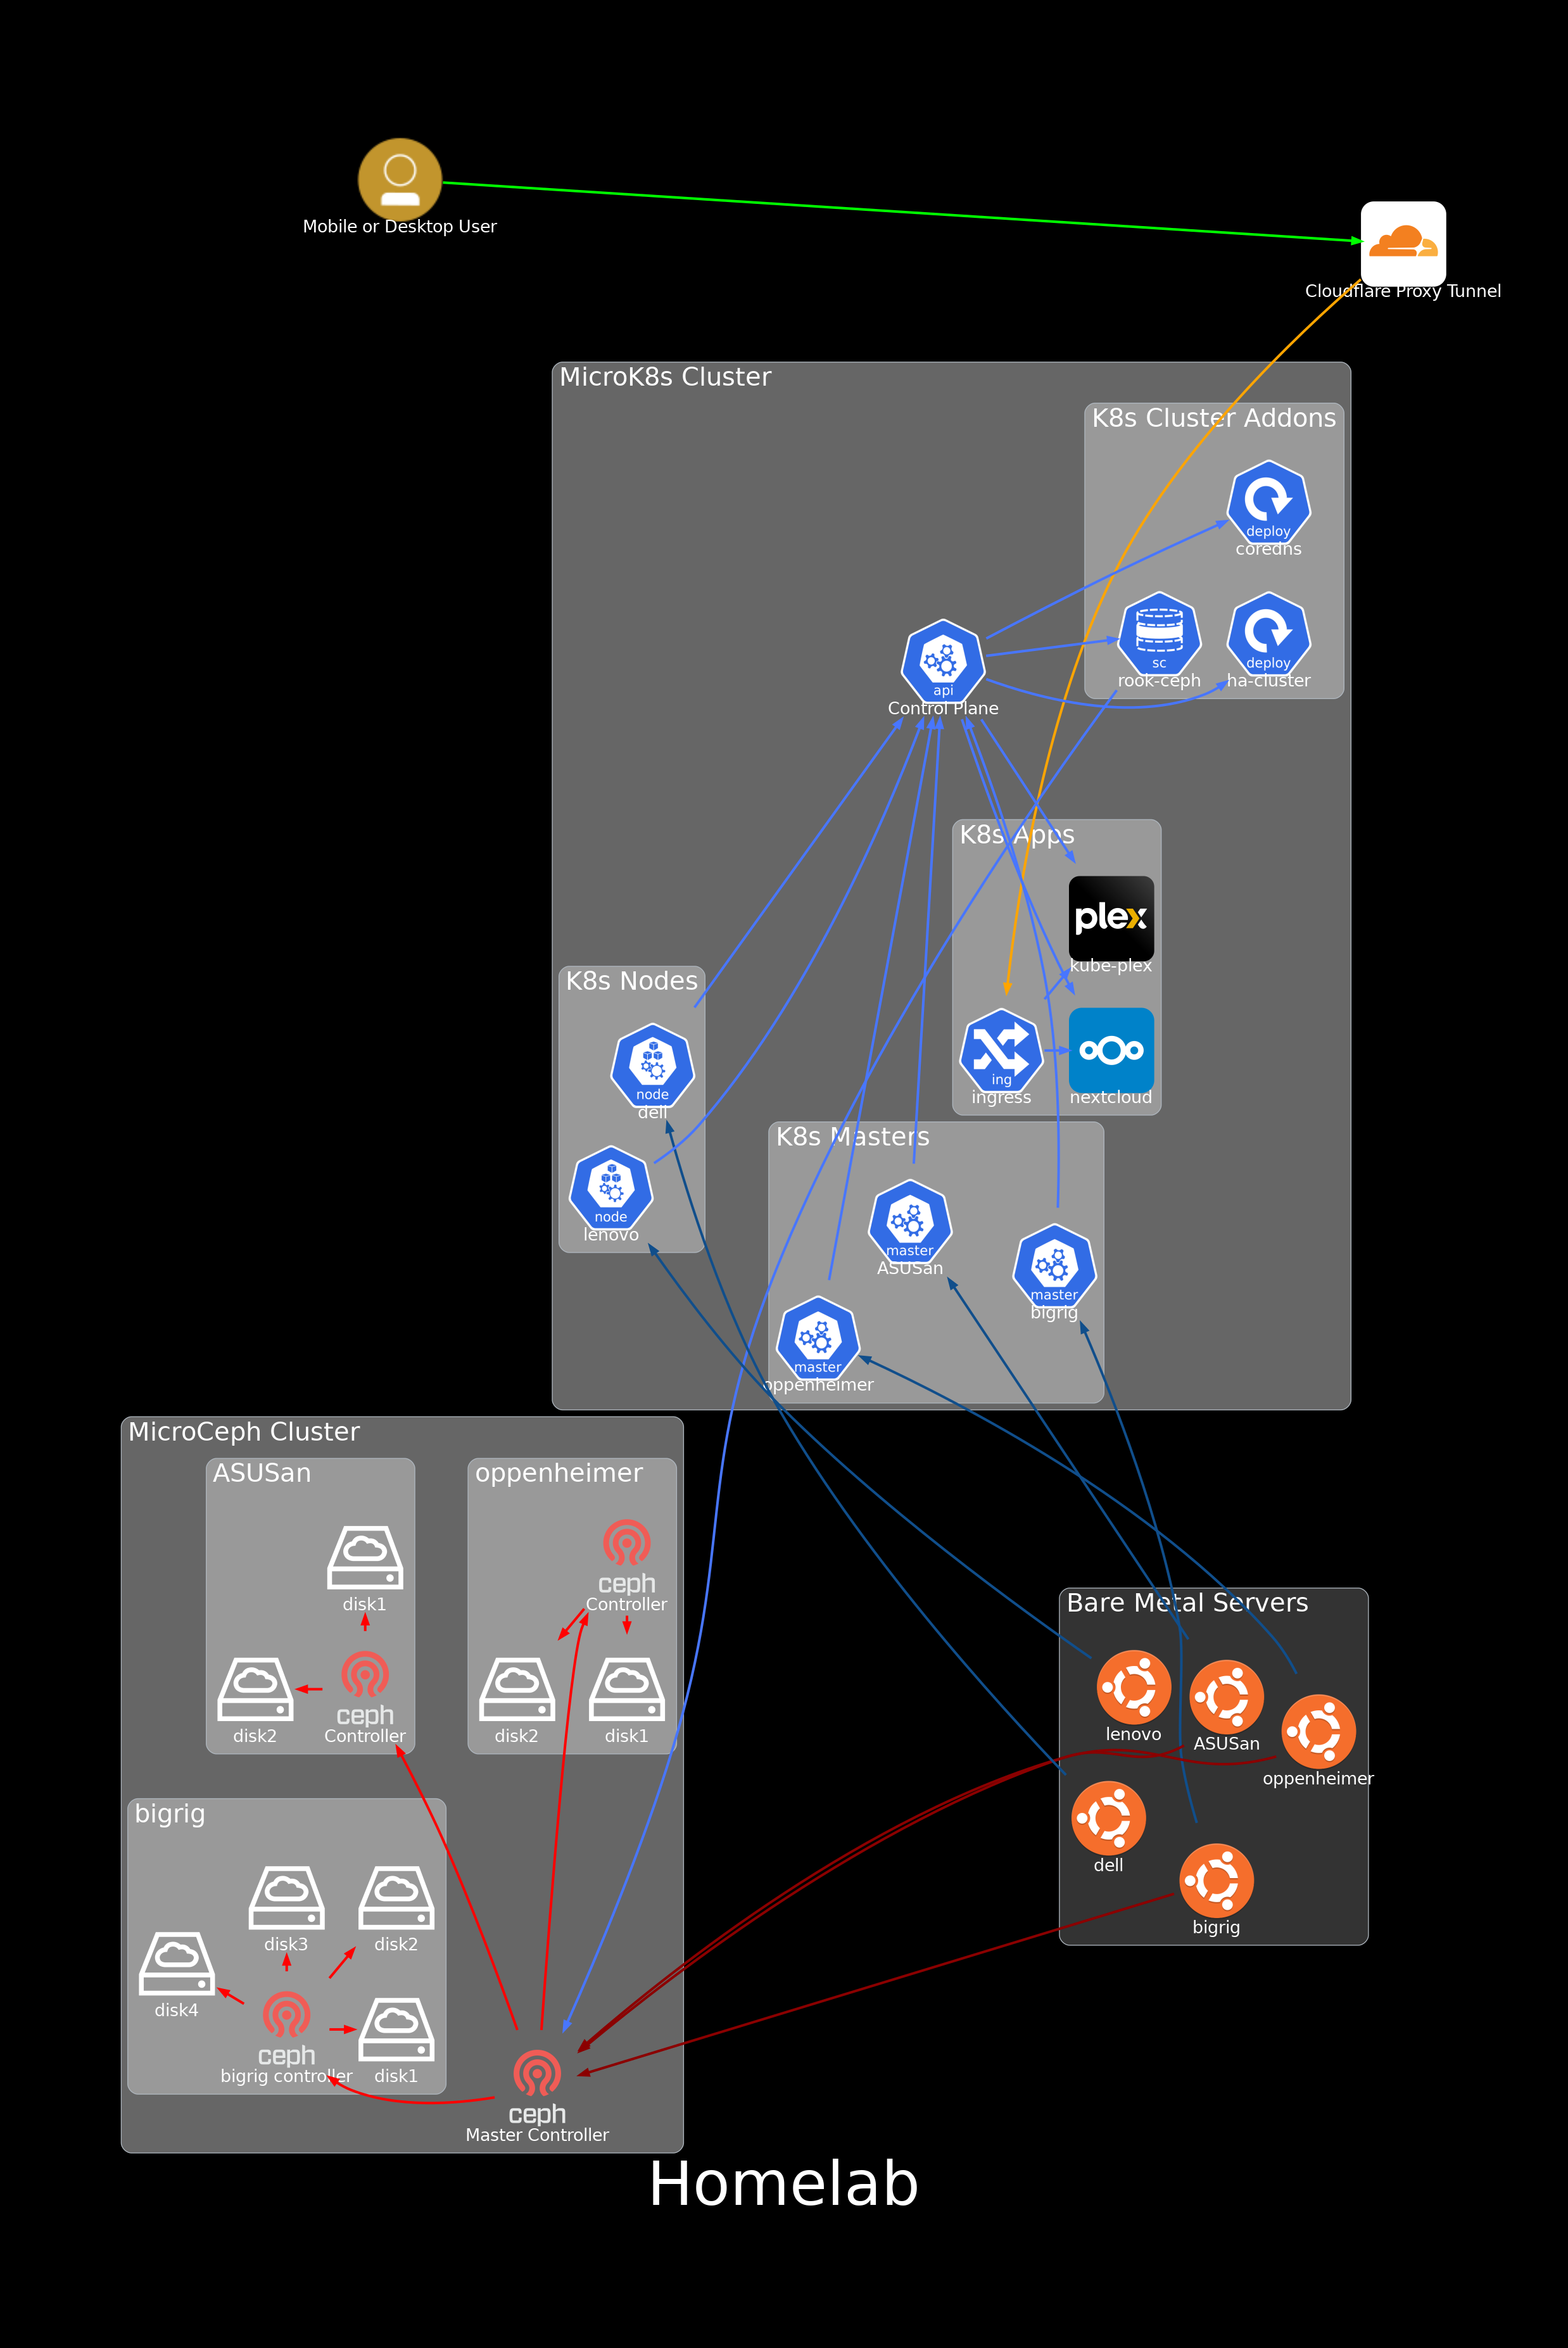

In [30]:
from diagrams                   import Diagram, Cluster, Edge
from diagrams.custom            import Custom
from diagrams.generic.os        import Ubuntu
from diagrams.k8s.compute       import Deployment
from diagrams.k8s.controlplane  import API
from diagrams.k8s.infra         import Master, Node
from diagrams.k8s.network       import Ingress
from diagrams.k8s.storage       import StorageClass
from diagrams.oci.storage       import StorageGatewayWhite
from diagrams.ibm.user          import User

# Attributes
## node
base_node_attr = { "fontcolor": "white", "fontsize": "20" }
## edge
base_edge_attr = { "color": "white", "weight": "100", "penwidth": "3", "overlap": "false" }
k8s_edge_attr  = base_edge_attr | { "color": "royalblue1" }
ceph_edge_attr = base_edge_attr | { "color": "red" }
user_edge_attr = base_edge_attr | { "color": "green", "weight": "500" }
baremetal_ceph_edge_attr = base_edge_attr | { "color": "darkred" }
baremetal_k8s_edge_attr  = base_edge_attr | { "color": "dodgerblue4" }
## cluster
cluster1_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray40" }
baremetal_attr = cluster1_attr | { "bgcolor": "gray20" }
cluster2_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray60" }
diagram_attr   = { "fontcolor": "white", "fontsize": "72", "bgcolor": "black", "layout": "fdp", "overlap": "false", "splines": "true" }

# Clusters and Nodes
with Diagram("Homelab", graph_attr=diagram_attr) as diag:
    user        = User("Mobile or Desktop User", **base_node_attr)
    cloudflare  = Custom("Cloudflare Proxy Tunnel", "./custom_icons/cloudflare.png", **base_node_attr)
    with Cluster("MicroCeph Cluster", graph_attr=cluster1_attr) as microceph:
        ceph_master_controller = Custom("Master Controller", "./custom_icons/ceph.png", **base_node_attr)
        with Cluster("bigrig", graph_attr=cluster2_attr) as bigrig_ceph:
            bigrig_ceph_controller = Custom("bigrig controller", "./custom_icons/ceph.png", **base_node_attr)
            bigrig_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            bigrig_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)
            bigrig_ceph_disk3 = StorageGatewayWhite("disk3", **base_node_attr)
            bigrig_ceph_disk4 = StorageGatewayWhite("disk4", **base_node_attr)

            bigrig_ceph_disks = [bigrig_ceph_disk1, bigrig_ceph_disk2, bigrig_ceph_disk3, bigrig_ceph_disk4]
        
        with Cluster("oppenheimer", graph_attr=cluster2_attr) as oppenheimer_ceph:
            oppenheimer_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **base_node_attr)
            oppenheimer_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            oppenheimer_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)

            oppenheimer_ceph_disks = [oppenheimer_ceph_disk1, oppenheimer_ceph_disk2]


        with Cluster("ASUSan", graph_attr=cluster2_attr) as ASUSan_ceph:
            ASUSan_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **base_node_attr)
            ASUSan_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            ASUSan_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)

            ASUSan_ceph_disks = [ASUSan_ceph_disk1, ASUSan_ceph_disk2]

    with Cluster("Bare Metal Servers", graph_attr=baremetal_attr) as baremetal_cluster:
        bigrig      = Ubuntu("bigrig",      **base_node_attr)
        oppenheimer = Ubuntu("oppenheimer", **base_node_attr)
        ASUSan      = Ubuntu("ASUSan",      **base_node_attr)
        lenovo      = Ubuntu("lenovo",      **base_node_attr)
        dell        = Ubuntu("dell",       **base_node_attr)

        baremetal_servers = [oppenheimer, bigrig, ASUSan]
    
    with Cluster("MicroK8s Cluster", graph_attr=cluster1_attr) as microk8s_cluster:
        k8s_controlplane = API("Control Plane", **base_node_attr)
        with Cluster("K8s Masters", graph_attr=cluster2_attr) as k8s_master3s_cluster:
            k8s_oppenheimer = Master("oppenheimer", **base_node_attr)
            k8s_bigrig = Master("bigrig",      **base_node_attr)
            k8s_ASUSan = Master("ASUSan",      **base_node_attr)

            k8s_masters = [k8s_oppenheimer, k8s_bigrig, k8s_ASUSan]

        with Cluster("K8s Nodes", graph_attr=cluster2_attr) as k8s_nodes_cluster:
            k8s_lenovo  = Node("lenovo", **base_node_attr)
            k8s_dell    = Node("dell", **base_node_attr)

            k8s_nodes = [k8s_lenovo, k8s_dell]

        with Cluster("K8s Apps", graph_attr=cluster2_attr) as k8s_deployments_cluster:
            kube_plex = Custom("kube-plex", "./custom_icons/plex.png", **base_node_attr)
            nextcloud = Custom("nextcloud", "./custom_icons/nextcloud.png", **base_node_attr)
            ingress   = Ingress("ingress", **base_node_attr)

            k8s_deployments = [kube_plex, nextcloud]

        with Cluster("K8s Cluster Addons", graph_attr=cluster2_attr) as k8s_addons_cluster:
            rook_ceph   = StorageClass("rook-ceph", **base_node_attr)
            coredns     = Deployment("coredns", **base_node_attr)
            ha_cluster  = Deployment("ha-cluster", **base_node_attr)

            k8s_cluster_addons = [rook_ceph, coredns, ha_cluster]

# Edge Connections
# baremetal nodes to k8s nodes
oppenheimer >> Edge(**baremetal_k8s_edge_attr) >> k8s_oppenheimer
bigrig      >> Edge(**baremetal_k8s_edge_attr) >> k8s_bigrig
ASUSan      >> Edge(**baremetal_k8s_edge_attr) >> k8s_ASUSan
lenovo      >> Edge(**baremetal_k8s_edge_attr) >> k8s_lenovo
dell        >> Edge(**baremetal_k8s_edge_attr) >> k8s_dell

# baremetal nodes to ceph controllers
oppenheimer >> Edge(**baremetal_ceph_edge_attr) >> ceph_master_controller # oppenheimer_ceph_controller
bigrig      >> Edge(**baremetal_ceph_edge_attr) >> ceph_master_controller # bigrig_ceph_controller
ASUSan      >> Edge(**baremetal_ceph_edge_attr) >> ceph_master_controller # ASUSan_ceph_controller
# lenovo      >> Edge(**base_edge_attr) >> ceph_master_controller # lenovo_ceph_controller

# k8s nodes
k8s_controlplane >> Edge(**k8s_edge_attr) >> k8s_deployments
k8s_controlplane >> Edge(**k8s_edge_attr) >> k8s_cluster_addons
ingress          >> Edge(**k8s_edge_attr) >> k8s_deployments
k8s_nodes        >> Edge(**k8s_edge_attr) >> k8s_controlplane
k8s_masters      >> Edge(**k8s_edge_attr) >> k8s_controlplane

# ceph nodes
oppenheimer_ceph_controller >> Edge(**ceph_edge_attr) >> oppenheimer_ceph_disks
bigrig_ceph_controller      >> Edge(**ceph_edge_attr) >> bigrig_ceph_disks
ASUSan_ceph_controller      >> Edge(**ceph_edge_attr) >> ASUSan_ceph_disks

ceph_master_controller >> Edge(**ceph_edge_attr) >> oppenheimer_ceph_controller
ceph_master_controller >> Edge(**ceph_edge_attr) >> bigrig_ceph_controller
ceph_master_controller >> Edge(**ceph_edge_attr) >> ASUSan_ceph_controller

# ceph to rook-ceph
ceph_master_controller << Edge(**k8s_edge_attr) << rook_ceph

# end user interactions
user >> Edge(**user_edge_attr) >> cloudflare >> Edge(**user_edge_attr | { "color": "orange" }) >> ingress

diag